In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt

from rocketPy import Quaternion

In [2]:
class SimpleRocket():
    
    def __init__(self):
        
        self.m0 = 40;
        self.c = 2000;
        
        self.A_ref = np.pi*0.15**2/4;
        
        self.ax_roll = np.array([0,0,1])
        self.ax_pitch = np.array([0,1,0])
        self.ax_yaw = np.array([1,0,0])
        
        self.inertia_matrix = np.diag([100,100,10])
        
        self.C_A = 0.5
        self.C_Na = 4
        self.static_margin = 1.5
        
        self.C_D_main_parachute = 0.8
        d_main_parachute = (16*0.3) # 16 ft parachute
        self.A_ref_main_parachute = np.pi*(d_main_parachute/2)**2
        
        self.C_D_drogue_parachute = 0.8
        d_drogue_parachute = (48*0.0254) # 48 in parachute
        self.A_ref_drogue_parachute = np.pi*(d_drogue_parachute/2)**2
        
        # location of the cp relative to the cg of the rocket
        self.cp = - (2*(self.A_ref/np.pi)**0.5) * self.static_margin * self.ax_roll
        
        self.thrust_axis = np.array([0.05,0,1])
        #self.thrust_axis = self.thrust_axis/la.norm(self.thrust_axis)
        
        self.stages = dict()
        
    #def stage_deploy_drogue(self, state):
        # takes in a state vector, returns a value
        # the event is triggered t_offset seconds later
        
        # return function, t_offset, direction
     #   return state.momentum[2], 
    # 
    def dynamics(self, time, state):
        
        z = state.pos[2]
        pz = state.momentum[2]
        if pz < 0:
            return self.dynamics_descent(time, state)
        else:
            return self.dynamics_ascent(time, state)
        
        
        
    def dynamics_descent(self, time, state):
        
        if state.pos[2] < 500:
            f_drag = self.f_drag_main_parachute(state)
        else:
            f_drag = self.f_drag_drogue_parachute(state)
        
        moments = np.array([0.,0.,0.])
        
        mdot = 0.
        
        return f_drag, moments, mdot
        
    def dynamics_ascent(self, time, state):
        
        # need to return the forces and moments acting at the cg in body fixed axes.
        # z points towards the nose
        # x points to the right fin
        # y completes right hand coord system
        
        # m_dot is a scalar, negative if the mass is decreasing
        
        # compute thrust force
        f_thrust, m_dot = self.f_thrust(state)
        
        # compute axial drag force
        f_axial = self.f_axial(state)
        
        f_normal = self.f_normal(state)
        
        # sum forces
        # in body axes
        forces = f_thrust + f_axial + f_normal;

        # sum moments
        # in body axes
        moment_f_normal = np.cross(self.cp, f_normal)
        #moment_f_thrust  = np.cross(3*self.cp, f_thrust)
        
        moments = np.array([0.,0.,0.])
        moments += moment_f_normal# + moment_f_thrust
        
        return forces, moments, m_dot
    
    
    def f_thrust(self, state):
        
        time = state.time
        
        if time < 3:
            f = 4000;
        else:
            f = 0;
        
        m_dot = -f/self.c
        
        return f*self.thrust_axis, m_dot
        
    def f_axial(self, state):
        
        q_inf = self.dynamic_pressure(state);
        F_A = q_inf * self.C_A * self.A_ref;
        
        # is aligned with negative z axis
        F_A = np.array([0,0, -F_A]);
        
        return F_A
    
    def f_drag_main_parachute(self, state):
        
        q_inf = self.dynamic_pressure(state);
        F_A = q_inf * self.C_D_main_parachute * self.A_ref_main_parachute;
        
        # is aligned with airspeed vector
        v_air_B = state.T_BE() @ self.v_air_cp(state)
        
        F_A = F_A * v_air_B/la.norm(v_air_B);
        
        return F_A
    
    def f_drag_drogue_parachute(self, state):
        
        q_inf = self.dynamic_pressure(state);
        F_A = q_inf * self.C_D_drogue_parachute * self.A_ref_drogue_parachute;
        
        # is aligned with airspeed vector
        v_air_B = state.T_BE() @ self.v_air_cp(state)
        
        F_A = F_A * v_air_B/la.norm(v_air_B);
        
        return F_A
    
    
    def f_normal(self, state):
        
        C_N = self.C_Na * self.alpha(state)
        
        q_inf = self.dynamic_pressure(state)
        
        F_N = q_inf * C_N * self.A_ref * self.normal2(state)
                
        return F_N

    
    ## these are implementation specific
    ## ie as a person designing the rocket, you need to define how you determine the aero forces, 
    ## so you own these equations
    ## the state just interfaces bewteen scipy solve ivp and rocket dynamics
    
        
    def dynamic_pressure(self, state):
        z = state.pos[2]
        
        # todo update to use the cp velocity
        v_air = self.v_air_cp(state)
        
        dynamic_pressure = 0.5 * state.env.rho(z) * v_air @ v_air
        
        return dynamic_pressure
    
    def v_body(self, state):
        """Returns the velocity of the body in earth coordinates"""
        
        return state.momentum/state.mass;
    
    def v_air_cg(self, state):
        """Returns the apparent airspeed at the CG in earth coordinates
        v_air_cg = -v_body + wind
        """
        return -self.v_body(state) + state.wind()
    
    #def v_air_p(self, p):
    #    """Computes the airspeed at some location p.
    #    p is the position vector of the point relative to the cg of the rocket in earth coordinates
    #    """
    #    # todo (high): update with 6DOF
    #    omega = np.array([0,0,0])
    #    # todo convert p to earth coordinates
    #    
    #    return self.v_air_cg(state) + np.cross(omega, p)
        
        
    def v_air_cp(self, state):
        """Returns the apparent airspeed at the CP
        accounts for the rotation rate of the body
        """
        
        #todo (high): update to account for the rotation rate
        
        return self.v_air_cg(state)
        
    def alpha(self, state, p=None):
        """Return the angle of attack of the air at some location on the body p (relative to the cg)"""
        
        
        # angle between roll axis and airspeed at p
        # if p is none, use the cp
        
        if p is not None:
            raise NotImplementedError
        
        v_air_cp = self.v_air_cp(state)
        
        # compute unit vector in direction of the airspeed
        v_air_cp_unit = v_air_cp/la.norm(v_air_cp)
        
        # get roll axis in earth coordinates
        neg_roll_axis = -state.T_EB() @ self.ax_roll
        
        np.testing.assert_almost_equal(la.norm(neg_roll_axis), 1.0)
        
        val = v_air_cp_unit @ neg_roll_axis
        
        val = np.clip(val, -1, 1) # may go every so slightly outside due to numerical issues
        
        alpha = np.arccos(val)
        
        return alpha
    
    def normal(self, state):
        """Gets the normal vector direction (direction of lift generation) in Body coordinates"""
        
        # earth axes roll axis
        roll = state.T_EB() @ self.ax_roll

        # get the airspeed vector
        v = self.v_air_cp(state)
        
        # convert to unit vector
        vhat = v/la.norm(v)
        
        # compute the normal direction
        n = np.cross(np.cross(roll, v), roll)
        
        # convert to unit vector
        n_hat = n/la.norm(n)
        
        # convert to body axes
        n_hat = state.T_BE() @ n_hat
        
        return n_hat
    
    def normal2(self, state):
        """Gets the normal vector direction (direction of lift generation) in Body coordinates"""
        
        # earth axes roll axis
        #roll = self.ax_roll

        # get the airspeed vector
        v = state.T_BE() @ self.v_air_cp(state)
        
        # convert to unit vector
        vhat = v/la.norm(v)
        
        # compute the normal direction
        n = np.cross(np.cross(self.ax_roll, v), self.ax_roll)
        
        # convert to unit vector
        n_hat = n/la.norm(n)
        
        # convert to body axes
        #n_hat = state.T_BE() @ n_hat
        
        return n_hat
    

In [3]:
A  = np.eye(3) + np.random.rand(3,3)*0.1-0.05
print(A)
A @ np.array([5,0,0])

[[ 0.99555526  0.00405844 -0.01409499]
 [ 0.0472207   0.99894733 -0.0345268 ]
 [ 0.02986743  0.04005213  0.99572146]]


array([4.97777628, 0.2361035 , 0.14933713])

In [4]:
class Env():
    
    def __init__(self, wind = np.array([0,0,0])):
        
        A  = np.eye(3) + np.random.rand(3,3)*0.1-0.05 # add some noise when initializing the wind
        self.wind = A @ wind
        
        return
    
    def rho(self, z):
        """ Return the density at some altitude in meters"""
        return 1.225
    
    def wind_vector(self, time=None, pos=None):
        #if pos[2] > 1000:
        #    return -10*np.array([self.wind[1], self.wind[0], self.wind[2]])
        #else:
            return self.wind

In [5]:
class State():
    
    def __init__(self, time=0, mass=1, position=np.array([0,0,0]), momentum=np.array([0,0,0]), quaternion=Quaternion(1,0,0,0), angular_momentum = np.array([0,0,0]), env=Env()):
        
        self.time = time;
        
        self.mass = mass;
        self.pos = position;
        self.momentum = momentum;
        self.quaternion = quaternion #no rotation
        self.angular_momentum = angular_momentum;
        
        self.env = env;
    
    def vector(self):
        """Convert state to vector"""
        # passes the quaternion's vector
        return np.hstack([[self.mass], self.pos, self.momentum, self.quaternion.q, self.angular_momentum]);
    
    def update(self,statev, time=None):
        # take a state vector and pass it to the internal objects
        if time is not None:
            self.time = time
            
        self.mass = statev[0]  
        self.pos = statev[1:4]
        self.momentum = statev[4:7]
        self.quaternion = Quaternion(*statev[7:11])
        self.angular_momentum = statev[11:14]
        
        return self
        
        
    def wind(self):
        """Returns the Earth coordinate wind vector at this state"""
        # maybe allow it to take some offset vector?
        # in either Earth or Body axes?
        
        # should be a deterministic function of state
        # for now a constant with time and altitude, blowing to the negative x direction
        return self.env.wind_vector(self.time, self.pos)
    
    
    def T_BE(self):
        """Rotation matrix from Earth axes to Body axes
            Therefore v_B = T_BE() @ v_E
        """
        return self.quaternion.rot_matrix().transpose()
        
        
    def T_EB(self):
        """Rotation matrix from from Body axes to Earth axes
            Therefore v_E = T_EB() @ v_B
        """
        
        return self.quaternion.rot_matrix()
    
    
    def __repr__(self):
        return f'State  {self.vector()}'

In [6]:
class Simulation():
    
    def __init__(self, rocket, state_initial):

        self.rocket = rocket
            
        self.ax_x = np.array([1,0,0])
        self.ax_y = np.array([0,1,0])
        self.ax_z = np.array([0,0,1]) # vertically upwards
        
        self.g0 = 9.81;
        self.g  = - self.g0*self.ax_z
        
        self.state = state_initial;
        
        self.launch_rail_length = 5;
        
        self.launch_angle = 6*np.pi/180
        self.launch_v = np.array([np.sin(self.launch_angle), 0, np.cos(self.launch_angle)])
        
        self.state.quaternion = Quaternion.from_angle(self.launch_angle, self.ax_y)
        
    
    def dynamics(self, time, statev):
        
        state = self.state;
        
        state.update(statev, time)
        
        # calculate the angular velocity of the rocket
        R = state.quaternion.rot_matrix()
        omega = R @ la.inv(self.rocket.inertia_matrix) @ R.T @ state.angular_momentum;
        # this omega is in earth coordinates, about the cg
        
        
        # get the rocket axis forces and moments
        forces_b, moments_b, m_dot = self.rocket.dynamics(time, state)
        
        # convert body axis forces into earth axis
        #px, py, pz = state.momentum;
        #th = np.arctan2(px,pz)
        R = state.T_EB() #np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])
        
        forces = R @ forces_b + state.mass*self.g;
        moments = R @ moments_b;
        
        
        # apply launch rail
        # compute v_cg
        V_cg = self.state.momentum/self.state.mass;
        if la.norm(state.pos) < self.launch_rail_length:
            V_cg = self.launch_v * np.dot(V_cg, self.launch_v);
            forces = self.launch_v * np.dot(forces, self.launch_v);
            moments = np.array([0.,0.,0.]) # no moments during launch rail
        
        # determine rate of change of quaternion
        d_quaternion = state.quaternion.rate_of_change(omega)
        
        # set derivatives
        d_mass = m_dot
        d_pos = V_cg
        d_momentum = forces;
        #d_quaternion = d_quat
        d_angular_momentum = moments;
        
        return np.hstack([d_mass, d_pos, d_momentum, d_quaternion, d_angular_momentum])
    
    
    def solve(self, t_span = [0,100]):
        # set initial state
        s0 = self.state.vector()
        
        # when im no longer at the rail
        def no_rail(t, y):
            pos = la.norm(y[1:4]) - self.launch_rail_length;
            return pos
        no_rail.terminal = False
        no_rail.direction = 1;
        
        def apogee(t, y):
            return y[6]# + 250*y[0] # when the velocity is -10 m/s
        apogee.terminal = False
        apogee.direction = -1;
        
        def landing(t, y):
            return y[3]
        landing.terminal = True
        landing.direction = -1;
        
        self.sim_result = spint.solve_ivp(self.dynamics, t_span, s0, dense_output=True, events=(no_rail, apogee, landing));
        
        self.output = self.sim_result.sol;
        
        return self.sim_result
        
        
    
        

In [7]:
def plot_v_xz(v):
    plt.arrow(0,0,v[0], v[2], length_includes_head=True, width=0.1)

In [8]:
r = SimpleRocket()

In [9]:
#env = Env(wind=np.array([-np.sin(30*np.pi/180),0,-np.cos(30*np.pi/180)]))
env = Env(wind=np.array([10,0,0]))

In [10]:
s0 = State(env = env)
s0.mass = 40;
s0.momentum = np.array([0,0,30*s0.mass])
q = Quaternion.from_angle(0, np.array([0,1,0]))
s0.quaternion = q

In [11]:
q

[1. 0. 0. 0.]

In [12]:
s0

State  [4.0e+01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.2e+03 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]

In [13]:
s0.T_EB() @ r.ax_roll

array([0., 0., 1.])

In [14]:
r.v_body(s0)

array([ 0.,  0., 30.])

In [15]:
r.v_air_cg(s0)

array([ 10.23217344,   0.35778326, -29.580457  ])

In [16]:
r.alpha(s0)*180/np.pi

19.091827639820874

In [17]:
r.normal(s0)

array([0.99938923, 0.03494514, 0.        ])

In [18]:
fn = r.f_normal(s0)
fn

array([14.12694424,  0.49396975, -0.        ])

In [19]:
r.cp

array([-0.   , -0.   , -0.225])

In [20]:
mn_b = np.cross(r.cp, fn)
mn_b

array([ 0.11114319, -3.17856245,  0.        ])

In [21]:
mn_e = s0.T_EB() @ mn_b
mn_e

array([ 0.11114319, -3.17856245,  0.        ])

In [22]:
env = Env(np.array([-5,10,0]))
s1 = State(quaternion=Quaternion(1,0,0,0), env=env)
s1.mass = 40
s1
sim = Simulation(r, s1)

In [23]:
sim = Simulation(r, s1)

In [24]:
sim.g

array([-0.  , -0.  , -9.81])

In [25]:
s1

State  [40.          0.          0.          0.          0.          0.
  0.          0.99862953  0.          0.05233596  0.          0.
  0.          0.        ]

In [26]:
r.dynamics(0, sim.state)

(array([ 195.8249679 ,    7.12980636, 3999.33967476]),
 array([1.60420643, 0.93938222, 0.        ]),
 -2.0)

In [27]:
%time sol = sim.solve(t_span=[0,10*60])

CPU times: user 1.25 s, sys: 105 ms, total: 1.36 s
Wall time: 776 ms


In [28]:
sol.message

'A termination event occurred.'

In [29]:
sol.success

True

In [30]:
sol;

In [31]:
sol.t_events

[array([0.33100831]), array([25.09522427]), array([231.48195327])]

Text(0.5, 1.0, 'Alpha')

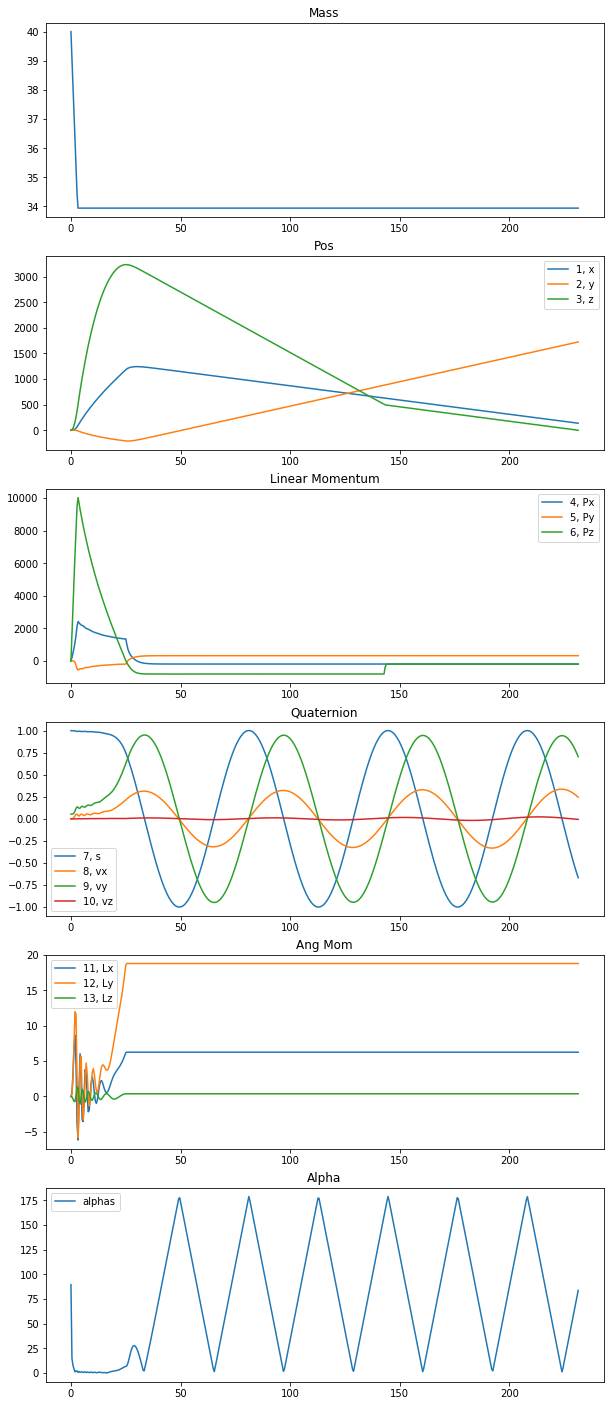

In [32]:
t_eval = np.linspace(sol.t[0], sol.t[-1], 500)


plt.figure(figsize=(10,25))
plt.subplot(611)
plt.plot(t_eval,sol.sol(t_eval)[0])

#for t in sol.t_events:
#    if len(t) is not 0:
#        plt.axvline(t, color='gray',linestyle='--')
    
plt.title('Mass')



plt.subplot(612)
plt.plot(t_eval,sol.sol(t_eval)[1], label='1, x')
plt.plot(t_eval,sol.sol(t_eval)[2], label='2, y')
plt.plot(t_eval,sol.sol(t_eval)[3], label='3, z')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
plt.legend()
plt.title('Pos')



plt.subplot(613)
plt.plot(t_eval,sol.sol(t_eval)[4], label='4, Px')
plt.plot(t_eval,sol.sol(t_eval)[5], label='5, Py')
plt.plot(t_eval,sol.sol(t_eval)[6], label='6, Pz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Linear Momentum')



plt.subplot(614)
plt.plot(t_eval,sol.sol(t_eval)[7], label='7, s')
plt.plot(t_eval,sol.sol(t_eval)[8], label='8, vx')
plt.plot(t_eval,sol.sol(t_eval)[9], label='9, vy')
plt.plot(t_eval,sol.sol(t_eval)[10], label='10, vz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Quaternion')



plt.subplot(615)
plt.plot(t_eval,sol.sol(t_eval)[11], label='11, Lx')
plt.plot(t_eval,sol.sol(t_eval)[12], label='12, Ly')
plt.plot(t_eval,sol.sol(t_eval)[13], label='13, Lz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Ang Mom')


plt.subplot(616)
alphas = [r.alpha(s1.update(sol.sol(t), 0))*180/np.pi for t in t_eval]
plt.plot(t_eval,alphas, label='alphas')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Alpha')



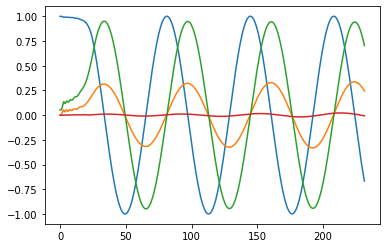

In [33]:
plt.plot(t_eval,sol.sol(t_eval)[7], label='7, s')
plt.plot(t_eval,sol.sol(t_eval)[8], label='8, vx')
plt.plot(t_eval,sol.sol(t_eval)[9], label='9, vy')
plt.plot(t_eval,sol.sol(t_eval)[10], label='10, vz')

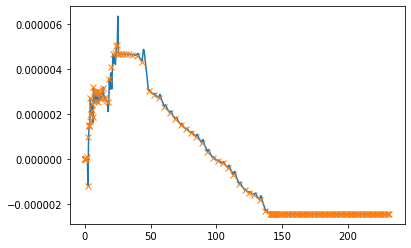

In [34]:
plt.plot(t_eval,[1-la.norm(sol.sol(t)[7:11]) for t in t_eval])
plt.plot(sol.t,[1-la.norm(sol.y[7:11,t]) for t in range(len(sol.t))], 'x')

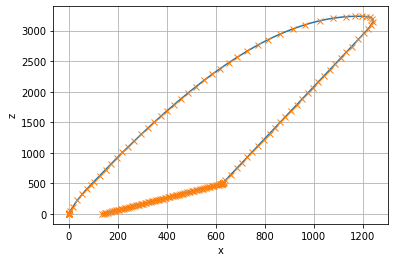

In [35]:
ax = plt.gca()
ax.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
ax.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

#ax.set_aspect('equal', 'datalim')
plt.grid()

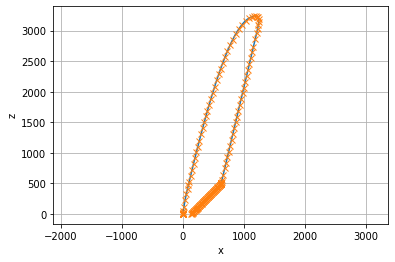

In [36]:
ax = plt.gca()
ax.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
ax.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

ax.set_aspect('equal', 'datalim')
plt.grid()

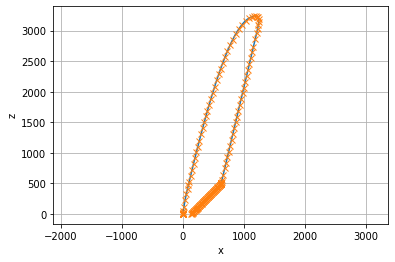

In [37]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.grid()

(-3, 5)

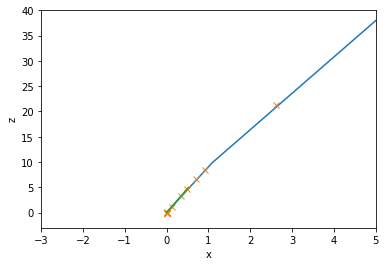

In [38]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')


plt.xlabel('x')
plt.ylabel('z')


xrail = [0, sim.launch_rail_length*np.sin(sim.launch_angle)]
zrail = [0, sim.launch_rail_length*np.cos(sim.launch_angle)]

xrail2 = [0, 10*sim.launch_rail_length*np.sin(sim.launch_angle)]
zrail2 = [0, 10*sim.launch_rail_length*np.cos(sim.launch_angle)]


plt.plot(xrail, zrail)

plt.ylim(-3,40)
plt.xlim(-3,5)


In [39]:
t_eval;

Text(0.5, 1.0, 'momentum angle')

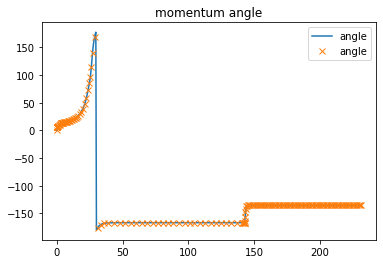

In [40]:
angle = 180*np.arctan2(sol.sol(t_eval)[4], sol.sol(t_eval)[6])/np.pi
angle_m = 180*np.arctan2(sol.y[4], sol.y[6])/np.pi

plt.plot(t_eval,angle, '-',label='angle')
plt.plot(sol.t,angle_m,'x', label='angle')
#for t in sol.t_events:
#    plt.axvline(t,linestyle='--',color='gray')
    
plt.legend()
plt.title('momentum angle')
#plt.xlim(0,3)
#plt.ylim(0,12)

Text(0.5, 1.0, 'orientation angle')

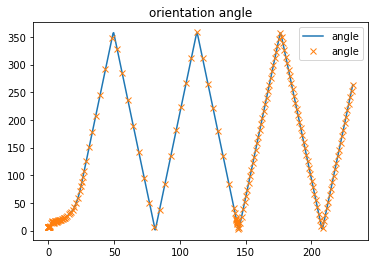

In [41]:
angle_quat = (180/np.pi)*2*np.arccos(sol.sol(t_eval)[7])
angle_m = (180/np.pi)*2*np.arccos(sol.y[7])

plt.plot(t_eval,angle_quat, '-',label='angle')
plt.plot(sol.t,angle_m,'x', label='angle')
#for t in sol.t_events:
#    plt.axvline(t,linestyle='--',color='gray')
    
plt.legend()
plt.title('orientation angle')
#plt.xlim(0,3)
#plt.ylim(0,12)

In [42]:
sol

  message: 'A termination event occurred.'
     nfev: 1214
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x115e767b8>
   status: 1
  success: True
        t: array([0.00000000e+00, 4.76768086e-07, 5.24444894e-06, 5.29212575e-05,
       5.29689343e-04, 5.29737020e-03, 5.29741788e-02, 1.60179404e-01,
       2.67384629e-01, 3.23941125e-01, 3.80497621e-01, 4.32651610e-01,
       6.82723392e-01, 1.06768976e+00, 1.56585487e+00, 2.15836172e+00,
       2.60720245e+00, 2.92489957e+00, 3.11993239e+00, 3.31496521e+00,
       3.64185344e+00, 4.00341281e+00, 4.35237881e+00, 4.69301001e+00,
       5.05069660e+00, 5.41606254e+00, 5.80831299e+00, 6.27206587e+00,
       6.70933060e+00, 7.16575203e+00, 7.62791856e+00, 8.08404792e+00,
       8.57431086e+00, 9.09816015e+00, 9.63193352e+00, 1.02229016e+01,
       1.08798909e+01, 1.15023158e+01, 1.21428949e+01, 1.28658986e+01,
       1.36022424e+01, 1.44443242e+01, 1.54155416e+01, 1.63097663e+01,
       1.73454088e+

In [43]:
sol.y[1]

array([0.00000000e+00, 1.07190566e-12, 1.29700607e-10, 1.32069740e-08,
       1.32310027e-06, 1.32356006e-04, 1.32579758e-02, 1.21670196e-01,
       3.40292163e-01, 5.00442212e-01, 6.99452109e-01, 9.27383974e-01,
       2.61631713e+00, 7.18332918e+00, 1.69047574e+01, 3.54222582e+01,
       5.63770488e+01, 7.57675934e+01, 8.95159709e+01, 1.03390960e+02,
       1.26328070e+02, 1.51071284e+02, 1.74328353e+02, 1.96600212e+02,
       2.19712924e+02, 2.43101768e+02, 2.67883740e+02, 2.96554557e+02,
       3.22894964e+02, 3.49794106e+02, 3.76604153e+02, 4.02740965e+02,
       4.30440268e+02, 4.59471384e+02, 4.88392377e+02, 5.19717741e+02,
       5.53889049e+02, 5.85759828e+02, 6.18052223e+02, 6.53806830e+02,
       6.89435982e+02, 7.29306866e+02, 7.74354786e+02, 8.15093486e+02,
       8.61445747e+02, 9.14834732e+02, 9.65734627e+02, 1.02718396e+03,
       1.08121762e+03, 1.13435035e+03, 1.17010626e+03, 1.19902706e+03,
       1.21591525e+03, 1.22959365e+03, 1.24040889e+03, 1.24213289e+03,
      

In [44]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter3d(
    x=sol.y[1], y=sol.y[2], z=sol.y[3],
    marker=dict(
        size=4,
        color=sol.t,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=1.25,
                y=-1.25,
                z=1.25,
            )
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'auto'
    ),
)

fig.show()

In [45]:
landing_site=[]
sols = []
for i in range(50):
    
    env = Env(np.array([-5,10,0]))
    
    s1 = State(quaternion=Quaternion(1,0,0,0), env=env)
    
    s1.mass = 40*(0.95 + 0.1*np.random.rand())
    
    sim = Simulation(r, s1)
    
    sol = sim.solve(t_span=[0,10*60])
    
    sols.append(sol)
    
    landing_site.append(sol.y[1:3,-1])

In [46]:
landing_site

[array([ 261.26676697, 1888.34066927]),
 array([ 348.47962182, 1647.46345456]),
 array([ 293.97855577, 1594.73393989]),
 array([ 235.52018251, 1824.92515617]),
 array([ 205.89102201, 1764.35730373]),
 array([ 231.04218454, 1659.92107786]),
 array([ 246.90239629, 1477.83532998]),
 array([ 197.57616149, 1752.91972245]),
 array([ 294.80320559, 1783.87691407]),
 array([ 273.90521093, 1721.88791148]),
 array([ 283.34925308, 1674.19928193]),
 array([ 242.65678653, 1848.99409139]),
 array([ 310.08833548, 1609.4952143 ]),
 array([ 275.99590855, 1674.6862107 ]),
 array([ 279.45212859, 1700.49168812]),
 array([ 372.5885244 , 1758.18655987]),
 array([ 211.53989793, 1637.06317327]),
 array([ 197.39742659, 1940.48405535]),
 array([ 319.65092611, 1735.72309329]),
 array([ 316.87045908, 1506.72479589]),
 array([ 325.94873867, 1686.88405241]),
 array([ 256.00161514, 1748.22456983]),
 array([ 310.35697074, 1695.09281903]),
 array([ 414.99194052, 1862.43150534]),
 array([ 290.76205745, 1546.82681558]),


In [47]:
x = [l[0] for l in landing_site]
y = [l[1] for l in landing_site]

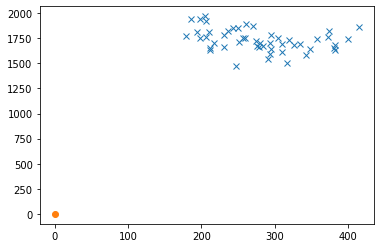

In [48]:
plt.plot(x, y,'x')
plt.plot(0,0,'o')

In [49]:
print(sum(x)/len(x))
print(sum(y)/len(y))

279.82873958148207
1732.5971225017447


In [50]:
data = [go.Scatter3d(
    x=sol.y[1], y=sol.y[2], z=sol.y[3],
    marker=dict(
        size=4,
        color=sol.t,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
) for sol in sols]

fig = go.Figure(data=data)

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=1.25,
                y=-1.25,
                z=1.25,
            )
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'auto'
    ),
)

fig.show()

In [51]:
origin = np.array([55+43.617/60, -4-48.667/60])

#origin = np.array([51.4983, -0.1768])

In [52]:
origin

array([55.72695   , -4.81111667])

In [53]:
R = 6371000
lat = [origin[0] + (l[1]/R)*180/np.pi for l in landing_site]
lon = [origin[1] + (l[0]/R)*180/np.pi for l in landing_site]

In [54]:
lat;

In [55]:
landing_site_radius = 3.704*1000 # meters

landing_circle_lat = [origin[0] + landing_site_radius*np.sin(th)/R*180/np.pi for th in np.linspace(0,2*np.pi)]
landing_circle_lon = [origin[1] + landing_site_radius*np.cos(th)/R*180/np.pi for th in np.linspace(0,2*np.pi)]



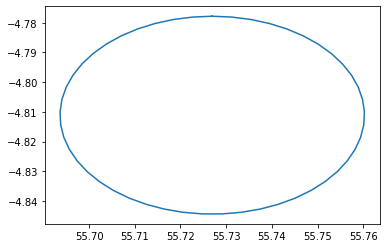

In [56]:
plt.plot(landing_circle_lat,landing_circle_lon)

In [57]:
fig = go.Figure()

data = [go.Scattermapbox(
    fill = "toself",
    lon = landing_circle_lon, lat =landing_circle_lat)
    ,
        go.Scattermapbox(lat=[origin[0]],
                  lon=[origin[1]],
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="green", size=12, opacity=0.8)),
    go.Scattermapbox(lat=lat,
                  lon=lon,
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="crimson", size=8, opacity=0.8))
       ]


layout = go.Layout(autosize=True,
                   mapbox_style="open-street-map",
                   mapbox= dict(zoom=12,
                                center= dict(
                                         lat=origin[0],
                                         lon=origin[1]),
                               layers = [dict(circle=dict(radius=20))]),
                    width=900,
                    height=600
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [58]:
R = 6371000
lat_path = origin[0] + (sol.y[1]/R)*180/np.pi
lon_path = origin[1] + (sol.y[2]/R)*180/np.pi


In [59]:
fig = go.Figure()

data = [go.Scattermapbox(lat=[origin[0]],
                  lon=[origin[1]],
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="green", size=12, opacity=0.8))
    ] + [go.Scattermapbox(lat=origin[0] + (sol.y[2]/R)*180/np.pi,
                  lon=origin[1] + (sol.y[1]/R)*180/np.pi,
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="black", size=2, opacity=0.8)) for sol in sols] + [go.Scattermapbox(lat=lat,
                  lon=lon,
                  mode="markers",
                  showlegend=False,
                  marker=dict(color="crimson", size=8, opacity=0.8))]



layout = go.Layout(autosize=True,
                   mapbox_style="open-street-map",
                   mapbox= dict(zoom=12,
                                center= dict(
                                         lat=origin[0],
                                         lon=origin[1])),
                    width=900,
                    height=600)
fig = go.Figure(data=data, layout=layout)
fig.show()